In [97]:
%load_ext autoreload
%autoreload 2
import time
import os
import seaborn as sns
import numpy as np
import pandas as pd
import sys

# from toolsets.API_gets import complete_smiles
from toolsets.search import string_search, num_search

from tqdm import tqdm
from toolsets.msp_file import read_one_spectrum
from toolsets.file_io import read_msp_files, readin_MSDIAL
from toolsets.spectra_operations import convert_nist_to_string, convert_string_to_nist, break_spectra, pack_spectra
from toolsets.isf_finder import isf_finder
from toolsets.spectra_operations import entropy_similarity_default

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
source_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/ISF_finder/ISF-finder_Umich_lipidomics'

In [101]:
def split_known_unknown(msp):
    msp_known = string_search(msp,'NAME','Unknown', reverse=True)
    msp_known = msp_known[~msp_known['NAME'].str.contains('riken', case = False)]
    msp_unknown = msp[~msp['Comment'].isin(msp_known['Comment'])]
    msp_known.reset_index(drop = True, inplace = True)
    msp_unknown.reset_index(drop = True, inplace = True)
    return (msp_known, msp_unknown)


In [106]:
def split_water_loss(msp_known, compound_pattern='cer'):
    msp_water_loss = msp_known[msp_known['NAME'].str.contains(compound_pattern, case=False)]
    msp_water_loss=string_search(msp_water_loss,'PRECURSORTYPE','[M+H-H2O]+')
    msp_compound = msp_known[~msp_known['Comment'].isin(msp_water_loss['Comment'])]
    msp_compound.reset_index(drop = True, inplace = True)
    msp_water_loss.reset_index(drop = True, inplace = True)
    return (msp_compound, msp_water_loss)

In [95]:
msp_neg =read_msp_files(os.path.join(source_dir, 'Umich_LIPn_202210191434_spectra_0.msp'))
msp_pos =read_msp_files(os.path.join(source_dir, 'Umich_LIPp_202210191429_spectra_0.msp'))
# txt=readin_MSDIAL(os.path.join(source_dir, 'Umich_LIPn_Height_0_202210191433.txt'))
# msp_unknown = string_search(msp, 'NAME','Unknown')
# msp_compound = string_search(msp, 'NAME','Unknown', reverse=True)

In [182]:
msp_pos_known, msp_pos_unknown  =split_known_unknown(msp_pos)

In [180]:
msp_pos_known

,spectrum,NAME,PRECURSORMZ,PRECURSORTYPE,RETENTIONTIME,Comment,Num Peaks,peaks
0,"[[43.01834, 191.0], [43.03857, 19.0], [43.0513...",Nicotinamide,123.0551,[M+H]+,0.442220,128,29,43.01834\t0.04037201\n43.03857\t0.00401606\n43...
1,"[[25.34124, 9.0], [25.50242, 29.0], [39.02368,...",Carnitine,162.1133,[M+H]+,0.408440,436,70,25.34124\t0.00030856\n25.50242\t0.00099424\n39...
2,"[[55.05426, 67.0], [55.07345, 6.0], [59.07407,...",w/o MS2:Tryptophan,205.0978,[M+Na]+,0.421105,884,35,55.05426\t0.02463235\n55.07345\t0.00220588\n59...
3,"[[85.02672, 150.0], [91.05247, 89.0], [172.141...",CAR 4:0,232.1549,[M+H]+,0.419617,1288,5,85.02672\t0.41208791\n91.05247\t0.24450549\n17...
4,"[[57.06898, 110.0], [83.04908, 204.0], [83.075...",CAR 5:0,246.1608,[M+H]+,0.414075,1552,12,57.06898\t0.04826678\n83.04908\t0.08951294\n83...
...,...,...,...,...,...,...,...,...
2057,"[[44.05816, 105.0], [44.07877, 7.0], [46.06618...",w/o MS2:SM 66:2;3O,1166.0670,[M+H]+,12.852520,19322,47,44.05816\t0.00503549\n44.07877\t0.0003357\n46....
2058,"[[88.1126, 776.0], [88.15797, 16.0], [88.47798...",TG 71:4;2O|TG 18:0_18:1_17:1;O(FA 18:1),1171.0590,[M+NH4]+,12.640450,19356,45,88.1126\t0.14750048\n88.15797\t0.00304125\n88....
2059,"[[45.04418, 174.0], [45.0597, 25.0], [64.72608...",TG 72:5;2O|TG 18:1_18:1_18:0;O(FA 18:2),1183.0560,[M+NH4]+,12.606210,19430,115,45.04418\t0.01631199\n45.0597\t0.00234368\n64....
2060,"[[46.0649, 73.0], [60.08251, 74.0], [60.09628,...",TG 72:4;2O|TG 18:0_18:1_18:2;O(FA 18:0),1185.0730,[M+NH4]+,12.676530,19438,113,46.0649\t0.0057219\n60.08251\t0.00580028\n60.0...


In [183]:
pos_mode_isf_search = isf_finder(msp_pos_known,msp_pos_unknown , only_precursor_found=False)

100%|██████████| 1467/1467 [03:37<00:00,  6.73it/s]


In [194]:
pos_mode_isf_search.to_csv(os.path.join(source_dir,'pos_mode_isf_search.csv' ), index = False)

In [195]:
pos_mode_isf_search

,isf_NAME,isf_PRECURSORMZ,isf_PRECURSORTYPE,isf_RETENTIONTIME,isf_Comment,isf_peaks,Compound_NAME,Compound_PRECURSORMZ,Compound_PRECURSORTYPE,Compound_RETENTIONTIME,Compound_Comment,Compound_peaks,Entropy_similarity,Precursor_found
0,Unknown,211.1933,[M+H]+,7.419512,916,38.96326\t0.02765648\n46.06477\t0.28425868\n46...,w/o MS2:ST 24:1;O3/16:3;1O,642.5154,[M+H]+,7.47990,6963,60.07996\t0.03724863\n60.09557\t0.00457038\n60...,0.712628,False
1,Unknown,211.1939,[M+H]+,12.879870,950,43.0546\t0.07972535\n43.08536\t0.00295632\n43....,w/o MS2:SM 66:2;3O,1166.0670,[M+H]+,12.85252,19322,44.05816\t0.00503549\n44.07877\t0.0003357\n46....,0.639305,False
2,Unknown,211.1940,[M+H]+,10.336840,962,41.4744\t0.00245761\n43.05365\t0.02924551\n46....,w/o MS2:SL 12:0;O/30:0;O,749.6429,[M+H]+,10.36077,9641,39.26524\t0.00619806\n46.06424\t0.02746866\n46...,0.755741,False
3,Unknown,211.1940,[M+H]+,10.336840,962,41.4744\t0.00245761\n43.05365\t0.02924551\n46....,w/o MS2:ST 28:2;O;Hex;FA 26:0,956.8264,[M+NH4]+,10.40929,17404,43.05307\t0.00463223\n46.06556\t0.04126895\n46...,0.636927,False
4,Unknown,211.1940,[M+H]+,10.336840,962,41.4744\t0.00245761\n43.05365\t0.02924551\n46....,w/o MS2:HexCer 16:1;3O/36:2;(2OH),962.7984,[M+NH4]+,10.42479,17506,43.0548\t0.00951153\n43.08437\t0.00029591\n46....,0.686671,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Unknown,1017.9590,[M+H]+,12.093490,18439,43.05378\t0.00545455\n46.06562\t0.01829037\n46...,w/o MS2:TG 8:0_11:0_44:5,1024.9270,[M+H]+,12.09745,18500,46.06445\t0.01303761\n69.34232\t0.00599431\n74...,0.727582,False
356,RIKEN P-VS1 ID-18203 from Mouse_Macrophage_WT_...,1076.8410,[M+2H]2+,5.560737,18843,27.28175\t0.00040736\n32.54466\t0.00169733\n35...,SM 34:1;2O,725.5587,[M+Na]+,5.56970,8934,45.03324\t0.00058848\n56.05121\t0.00074737\n56...,0.612685,False
357,Unknown,1165.0620,[M+H]+,12.874540,19312,43.056\t0.00458355\n43.07325\t0.00069845\n46.0...,w/o MS2:SM 66:2;3O,1166.0670,[M+H]+,12.85252,19322,44.05816\t0.00503549\n44.07877\t0.0003357\n46....,0.787922,False
358,Unknown,1177.0610,[M+H]+,12.824060,19396,43.0557\t0.00703295\n43.0732\t0.00034447\n59.7...,TG 72:3;2O|TG 18:0_18:1_18:1;O(FA 18:0),1187.0870,[M+NH4]+,12.73907,19450,43.05351\t0.00365108\n60.08028\t0.01302546\n85...,0.628470,False


In [1]:
neg_mode_isf_search

NameError: name 'neg_mode_isf_search' is not defined

In [187]:
msp_neg_known, msp_neg_unknown  =split_known_unknown(msp_neg)

In [188]:
neg_mode_isf_search = isf_finder(msp_neg_known,msp_neg_unknown , only_precursor_found=False)

100%|██████████| 1614/1614 [07:02<00:00,  3.82it/s]


In [190]:
neg_mode_isf_search.to_csv(os.path.join(source_dir, 'neg_mode_isf_search.csv'))

In [186]:
pos_mode_isf_search.to_csv(os.path.join(source_dir, 'pos_mode_isf_search.csv'))

In [179]:
pos_mode_isf_search

,isf_NAME,isf_PRECURSORMZ,isf_PRECURSORTYPE,isf_RETENTIONTIME,isf_Comment,isf_peaks,Compound_NAME,Compound_PRECURSORMZ,Compound_PRECURSORTYPE,Compound_RETENTIONTIME,Compound_Comment,Compound_peaks,Entropy_similarity,Precursor_found


In [108]:
msp_compound, msp_water_loss = split_water_loss(msp_pos_known)

In [110]:
msp_water_loss

,spectrum,NAME,PRECURSORMZ,PRECURSORTYPE,RETENTIONTIME,Comment,Num Peaks,peaks
0,"[[80.9469, 111.0], [88.11243, 28.0], [101.0401...",Cer 30:3;4O,492.4052,[M+H-H2O]+,4.058493,4233,19,80.9469\t0.07092652\n88.11243\t0.01789137\n101...
1,"[[57.06882, 112.0], [60.04371, 199.0], [71.084...",Cer 32:1;2O|Cer 16:1;2O/16:0,492.4779,[M+H-H2O]+,5.798461,4236,49,57.06882\t0.01387684\n60.04371\t0.02465618\n71...
2,"[[27.55839, 6.0], [66.74819, 6.0], [73.77707, ...",Cer 33:1;2O|Cer 17:1;2O/16:0,506.4939,[M+H-H2O]+,6.155385,4385,28,27.55839\t0.00155925\n66.74819\t0.00155925\n73...
3,"[[67.05524, 75.0], [80.68571, 13.0], [82.06561...",Cer 34:2;2O|Cer 18:2;2O/16:0,518.4928,[M+H-H2O]+,5.914893,4542,48,67.05524\t0.00704556\n80.68571\t0.00122123\n82...
4,"[[45.03322, 118.0], [57.06935, 188.0], [111.11...",Cer 34:1;2O|Cer 18:1;2O/16:0,520.5096,[M+H-H2O]+,6.521748,4570,25,45.03322\t0.01689818\n57.06935\t0.02692253\n11...
...,...,...,...,...,...,...,...,...
98,"[[114.96134, 16.0], [146.9832, 93.0], [203.053...",HexCer 46:2;4O,880.7216,[M+H-H2O]+,9.374274,14691,35,114.96134\t0.0011325\n146.9832\t0.00658267\n20...
99,"[[28.88815, 109.0], [40.96226, 104.0], [41.037...",Cer 60:5;3O|Cer 24:3;2O/36:2;O,892.8328,[M+H-H2O]+,11.687300,15206,257,28.88815\t0.00022144\n40.96226\t0.00021129\n41...
100,"[[45.04476, 210.0], [45.06639, 10.0], [47.7364...",HexCer 50:5;2O|HexCer 18:1;2O/32:4,898.7454,[M+H-H2O]+,8.454129,15401,92,45.04476\t0.01837431\n45.06639\t0.00087497\n47...
101,"[[35.86839, 6.0], [44.08289, 9.0], [57.06939, ...",Cer 60:2;3O|Cer 18:1;2O/42:1;O,898.8944,[M+H-H2O]+,12.411840,15411,64,35.86839\t0.00181433\n44.08289\t0.0027215\n57....


In [136]:
from toolsets.isf_finder import isf_finder
isf_result_cer = isf_finder(msp_water_loss, msp_compound)

100%|██████████| 103/103 [00:12<00:00,  8.54it/s]


In [189]:
isf_result_cer.to_csv(os.path.join(source_dir, 'isf_method_validation.csv'))

In [138]:
test_set_cer_not_found = msp_water_loss[~msp_water_loss['Comment'].isin(isf_result_cer['isf_Comment'])]

In [122]:
len(isf_result_cer['isf_candidate_Comment'].unique())

39

In [130]:
test_set_cer_not_found

,spectrum,NAME,PRECURSORMZ,PRECURSORTYPE,RETENTIONTIME,Comment,Num Peaks,peaks,if_exist
0,"[[80.9469, 111.0], [88.11243, 28.0], [101.0401...",Cer 30:3;4O,492.4052,[M+H-H2O]+,4.058493,4233,19,80.9469\t0.07092652\n88.11243\t0.01789137\n101...,False
1,"[[60.04469, 574.0], [67.0549, 143.0], [93.0700...",Cer 36:1;2O|Cer 18:1;2O/18:0,548.5397,[M+H-H2O]+,6.562250,4990,37,60.04469\t0.07654354\n67.0549\t0.01906921\n93....,False
2,"[[36.34042, 5.0], [62.06047, 428.0], [62.09668...",Cer 38:2;3O|Cer 21:1;2O/17:1;O,590.5491,[M+H-H2O]+,7.526916,5738,31,36.34042\t0.0004672\n62.06047\t0.03999252\n62....,False
3,"[[57.06842, 13.0], [86.05955, 138.0], [88.4501...",Cer 38:1;3O|Cer 18:1;2O/20:0;O,592.5666,[M+H-H2O]+,7.390200,5778,34,57.06842\t0.00331548\n86.05955\t0.0351951\n88....,False
4,"[[65.70772, 7.0], [71.29317, 11.0], [96.08858,...",Cer 40:2;2O|Cer 18:1;2O/22:1,602.5868,[M+H-H2O]+,7.983387,6003,45,65.70772\t0.00121317\n71.29317\t0.00190641\n96...,False
...,...,...,...,...,...,...,...,...,...
59,"[[114.96134, 16.0], [146.9832, 93.0], [203.053...",HexCer 46:2;4O,880.7216,[M+H-H2O]+,9.374274,14691,35,114.96134\t0.0011325\n146.9832\t0.00658267\n20...,False
60,"[[28.88815, 109.0], [40.96226, 104.0], [41.037...",Cer 60:5;3O|Cer 24:3;2O/36:2;O,892.8328,[M+H-H2O]+,11.687300,15206,257,28.88815\t0.00022144\n40.96226\t0.00021129\n41...,False
61,"[[45.04476, 210.0], [45.06639, 10.0], [47.7364...",HexCer 50:5;2O|HexCer 18:1;2O/32:4,898.7454,[M+H-H2O]+,8.454129,15401,92,45.04476\t0.01837431\n45.06639\t0.00087497\n47...,False
62,"[[35.86839, 6.0], [44.08289, 9.0], [57.06939, ...",Cer 60:2;3O|Cer 18:1;2O/42:1;O,898.8944,[M+H-H2O]+,12.411840,15411,64,35.86839\t0.00181433\n44.08289\t0.0027215\n57....,False


In [133]:
from toolsets.isf_finder import truncate_msms
def evaluate_negatives(test_set_cer_not_found, msp_compound):
    if_exist = []
    entropy_similarity = []
    test_set_cer_not_found.reset_index(inplace=True, drop=True)
    for index, row in test_set_cer_not_found.iterrows():
        test_candidates = num_search(msp_compound, 'RETENTIONTIME',row['RETENTIONTIME'],direction='between', step = 6/60, inclusion=True )
        test_candidates=string_search(test_candidates, 'NAME', row['NAME'])
        if len(test_candidates)==0:
            if_exist.append(False)
            entropy_similarity.append(-1)
        else:
            if_exist.append(True)
            entropy_sim_inner = []
            for inner_index, inner_row in test_candidates.iterrows():
                entropy_sim_inner.append(entropy_similarity_default(row['peaks'],truncate_msms(inner_row['peaks'], row['PRECURSORMZ'])))
            entropy_similarity.append(max(entropy_sim_inner))
    test_set_cer_not_found['if_exist']= if_exist
    test_set_cer_not_found['entropy_similarity']= entropy_similarity
    return (test_set_cer_not_found)

In [147]:
def evaluate_positives(isf_result):
    data_tp = pd.DataFrame()
    data_fp = pd.DataFrame()
    evaluations = []
    for isf in isf_result['isf_NAME'].unique():
        data_temp = string_search(isf_result,'isf_NAME', isf)
        data_temp_compound = string_search(data_temp, 'Compound_NAME', isf)
        if len(data_temp_compound)>0:
            data_tp=data_tp.append(data_temp)
        else:
            data_fp=data_fp.append(data_temp)
    return (data_tp, data_fp)



In [152]:
def further_cleanup(data_tp):
    data_return = pd.DataFrame()
    for isf in data_tp['isf_NAME'].unique():
        data_temp = string_search(data_tp,'isf_NAME', isf)
        data_temp_compound = string_search(data_temp, 'Compound_NAME', isf)
        data_return = data_return.append(data_temp_compound)
    return (data_return)

In [153]:
data_tp_only=further_cleanup(data_tp)

In [158]:
isf_result_cer

,isf_NAME,isf_PRECURSORMZ,isf_PRECURSORTYPE,isf_RETENTIONTIME,isf_Comment,isf_peaks,Compound_NAME,Compound_PRECURSORMZ,Compound_PRECURSORTYPE,Compound_RETENTIONTIME,Compound_Comment,Compound_peaks,Entropy_similarity,Precursor_found
0,Cer 32:1;2O|Cer 16:1;2O/16:0,492.4779,[M+H-H2O]+,5.798461,4236,57.06882\t0.01387684\n60.04371\t0.02465618\n71...,Cer 32:1;2O|Cer 16:1;2O/16:0,510.4880,[M+H]+,5.799152,4453,38.96334\t0.00489191\n38.99703\t0.00014646\n46...,0.795114,True
1,Cer 33:1;2O|Cer 17:1;2O/16:0,506.4939,[M+H-H2O]+,6.155385,4385,27.55839\t0.00155925\n66.74819\t0.00155925\n73...,Cer 33:1;2O|Cer 17:1;2O/16:0,524.5045,[M+H]+,6.154627,4632,30.03276\t0.00123173\n43.05368\t6.972e-05\n46....,0.678992,True
2,Cer 34:2;2O|Cer 18:2;2O/16:0,518.4928,[M+H-H2O]+,5.914893,4542,67.05524\t0.00704556\n80.68571\t0.00122123\n82...,Cer 34:2;2O|Cer 18:2;2O/16:0,536.5042,[M+H]+,5.913251,4797,30.41305\t0.00522317\n67.05316\t0.00884378\n67...,0.698308,True
3,Cer 34:1;2O|Cer 18:1;2O/16:0,520.5096,[M+H-H2O]+,6.521748,4570,45.03322\t0.01689818\n57.06935\t0.02692253\n11...,Cer 34:1;2O|Cer 18:1;2O/16:0,538.5206,[M+H]+,6.522254,4843,37.86623\t0.00010456\n55.05582\t0.00093429\n56...,0.795452,True
4,Cer 34:1;2O|Cer 18:1;2O/16:0,520.5096,[M+H-H2O]+,6.521748,4570,45.03322\t0.01689818\n57.06935\t0.02692253\n11...,HexCer 36:1;2O|HexCer 18:1;2O/18:0,728.6039,[M+H]+,6.568336,9036,41.03971\t0.00039408\n43.01847\t0.00037862\n43...,0.689715,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,HexCer 42:2;3O|HexCer 18:1;2O/24:1;O,808.6680,[M+H-H2O]+,7.790556,11726,29.56089\t9.64e-05\n43.01842\t0.00017564\n43.0...,HexCer 42:2;3O|HexCer 18:1;2O/24:1;O,826.6780,[M+H]+,7.794815,12474,38.89786\t5.071e-05\n39.61248\t4.837e-05\n41.0...,0.943155,True
63,HexCer 42:1;3O|HexCer 18:1;2O/24:0;O,810.6841,[M+H-H2O]+,8.496704,11819,28.8228\t8.184e-05\n29.43348\t4.89e-05\n29.751...,Cer 42:1;3O|Cer 18:1;2O/24:0;O,666.6410,[M+H]+,8.497801,7534,41.03878\t0.00104125\n55.05135\t0.0023315\n55....,0.747045,False
64,HexCer 44:2;2O|HexCer 18:1;2O/26:1,820.7050,[M+H-H2O]+,8.625407,12206,26.24317\t0.00010341\n45.21414\t0.0002216\n55....,Cer 40:1;2O|Cer 18:1;2O/22:0,622.6137,[M+H]+,8.684034,6462,60.04042\t0.00635295\n71.08508\t0.00095575\n73...,0.607584,False
65,HexCer 44:2;2O|HexCer 18:1;2O/26:1,820.7050,[M+H-H2O]+,8.625407,12206,26.24317\t0.00010341\n45.21414\t0.0002216\n55....,HexCer 42:1;2O|HexCer 18:1;2O/24:0,812.6990,[M+H]+,8.675859,11900,43.01873\t0.00045446\n43.05289\t0.00145634\n43...,0.657006,False


In [157]:
len(isf_result_cer['isf_NAME'].unique())

32

In [154]:
data_tp_only

,isf_NAME,isf_PRECURSORMZ,isf_PRECURSORTYPE,isf_RETENTIONTIME,isf_Comment,isf_peaks,Compound_NAME,Compound_PRECURSORMZ,Compound_PRECURSORTYPE,Compound_RETENTIONTIME,Compound_Comment,Compound_peaks,Entropy_similarity,Precursor_found
0,Cer 32:1;2O|Cer 16:1;2O/16:0,492.4779,[M+H-H2O]+,5.798461,4236,57.06882\t0.01387684\n60.04371\t0.02465618\n71...,Cer 32:1;2O|Cer 16:1;2O/16:0,510.4880,[M+H]+,5.799152,4453,38.96334\t0.00489191\n38.99703\t0.00014646\n46...,0.795114,True
1,Cer 33:1;2O|Cer 17:1;2O/16:0,506.4939,[M+H-H2O]+,6.155385,4385,27.55839\t0.00155925\n66.74819\t0.00155925\n73...,Cer 33:1;2O|Cer 17:1;2O/16:0,524.5045,[M+H]+,6.154627,4632,30.03276\t0.00123173\n43.05368\t6.972e-05\n46....,0.678992,True
2,Cer 34:2;2O|Cer 18:2;2O/16:0,518.4928,[M+H-H2O]+,5.914893,4542,67.05524\t0.00704556\n80.68571\t0.00122123\n82...,Cer 34:2;2O|Cer 18:2;2O/16:0,536.5042,[M+H]+,5.913251,4797,30.41305\t0.00522317\n67.05316\t0.00884378\n67...,0.698308,True
3,Cer 34:1;2O|Cer 18:1;2O/16:0,520.5096,[M+H-H2O]+,6.521748,4570,45.03322\t0.01689818\n57.06935\t0.02692253\n11...,Cer 34:1;2O|Cer 18:1;2O/16:0,538.5206,[M+H]+,6.522254,4843,37.86623\t0.00010456\n55.05582\t0.00093429\n56...,0.795452,True
5,Cer 35:1;2O|Cer 19:1;2O/16:0,534.5250,[M+H-H2O]+,6.884373,4763,43.05419\t0.01098901\n50.51033\t0.0008311\n56....,Cer 35:1;2O|Cer 19:1;2O/16:0,552.5356,[M+H]+,6.874583,5082,25.90779\t0.00021005\n32.15372\t0.00024506\n32...,0.812092,True
6,Cer 36:2;2O|Cer 18:2;2O/18:0,546.5251,[M+H-H2O]+,6.645620,4962,56.04802\t0.02704589\n56.06617\t0.00191939\n88...,Cer 36:2;2O|Cer 18:2;2O/18:0,564.5355,[M+H]+,6.644971,5263,56.29996\t0.00049838\n57.03449\t0.00422696\n57...,0.694532,True
7,Cer 36:1;2O|Cer 18:1;2O/18:0,548.5410,[M+H-H2O]+,7.261911,4993,36.34868\t8.551e-05\n41.03781\t0.00012399\n43....,Cer 36:1;2O|Cer 18:1;2O/18:0,566.5516,[M+H]+,7.262274,5300,38.96412\t0.00121861\n38.97581\t0.00016332\n56...,0.871733,True
10,Cer 37:1;2O|Cer 19:1;2O/18:0,562.5566,[M+H-H2O]+,7.505844,5221,38.96527\t0.00418545\n46.06636\t0.01625885\n46...,Cer 37:1;2O|Cer 19:1;2O/18:0,580.5675,[M+H]+,7.503470,5577,45.04551\t0.02258926\n45.08066\t0.00145737\n67...,0.649125,True
11,Cer 38:2;2O|Cer 18:2;2O/20:0,574.5543,[M+H-H2O]+,7.372484,5436,60.04437\t0.02755566\n69.06776\t0.00836511\n69...,Cer 38:2;2O|Cer 18:2;2O/20:0,592.5660,[M+H]+,7.356333,5776,52.59546\t0.00035528\n56.04913\t0.01225722\n56...,0.720043,True
12,Cer 38:1;2O|Cer 20:1;2O/18:0,576.5718,[M+H-H2O]+,7.997074,5498,56.04987\t0.00819582\n56.09683\t0.00012585\n57...,Cer 38:1;2O|Cer 20:1;2O/18:0,594.5827,[M+H]+,7.997410,5812,42.32231\t0.00059177\n57.06936\t0.00526365\n58...,0.853455,True


In [150]:
len(isf_result_cer['isf_NAME'].unique())

32

33

2

In [148]:
data_tp, data_fp = evaluate_positives(isf_result_cer)

In [172]:
len(data_tp['isf_Comment'].unique())

33

In [163]:
len(isf_result_cer['isf_Comment'].unique())

35

In [164]:
len(data_fp['isf_Comment'].unique())

2

<AxesSubplot:xlabel='Entropy_similarity', ylabel='Density'>

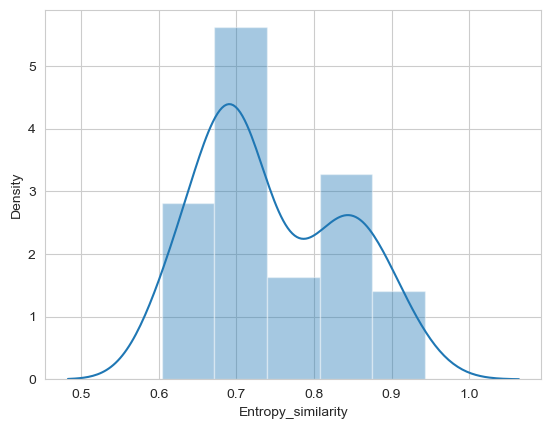

In [170]:
import seaborn as sns
sns.distplot(data_tp['Entropy_similarity'])

In [165]:
len(data_tp['isf_Comment'].unique())

33

In [ ]:
len()

In [151]:
data_tp

,isf_NAME,isf_PRECURSORMZ,isf_PRECURSORTYPE,isf_RETENTIONTIME,isf_Comment,isf_peaks,Compound_NAME,Compound_PRECURSORMZ,Compound_PRECURSORTYPE,Compound_RETENTIONTIME,Compound_Comment,Compound_peaks,Entropy_similarity,Precursor_found
0,Cer 32:1;2O|Cer 16:1;2O/16:0,492.4779,[M+H-H2O]+,5.798461,4236,57.06882\t0.01387684\n60.04371\t0.02465618\n71...,Cer 32:1;2O|Cer 16:1;2O/16:0,510.4880,[M+H]+,5.799152,4453,38.96334\t0.00489191\n38.99703\t0.00014646\n46...,0.795114,True
1,Cer 33:1;2O|Cer 17:1;2O/16:0,506.4939,[M+H-H2O]+,6.155385,4385,27.55839\t0.00155925\n66.74819\t0.00155925\n73...,Cer 33:1;2O|Cer 17:1;2O/16:0,524.5045,[M+H]+,6.154627,4632,30.03276\t0.00123173\n43.05368\t6.972e-05\n46....,0.678992,True
2,Cer 34:2;2O|Cer 18:2;2O/16:0,518.4928,[M+H-H2O]+,5.914893,4542,67.05524\t0.00704556\n80.68571\t0.00122123\n82...,Cer 34:2;2O|Cer 18:2;2O/16:0,536.5042,[M+H]+,5.913251,4797,30.41305\t0.00522317\n67.05316\t0.00884378\n67...,0.698308,True
3,Cer 34:1;2O|Cer 18:1;2O/16:0,520.5096,[M+H-H2O]+,6.521748,4570,45.03322\t0.01689818\n57.06935\t0.02692253\n11...,Cer 34:1;2O|Cer 18:1;2O/16:0,538.5206,[M+H]+,6.522254,4843,37.86623\t0.00010456\n55.05582\t0.00093429\n56...,0.795452,True
4,Cer 34:1;2O|Cer 18:1;2O/16:0,520.5096,[M+H-H2O]+,6.521748,4570,45.03322\t0.01689818\n57.06935\t0.02692253\n11...,HexCer 36:1;2O|HexCer 18:1;2O/18:0,728.6039,[M+H]+,6.568336,9036,41.03971\t0.00039408\n43.01847\t0.00037862\n43...,0.689715,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,HexCer 42:2;3O|HexCer 18:1;2O/24:1;O,808.6680,[M+H-H2O]+,7.790556,11726,29.56089\t9.64e-05\n43.01842\t0.00017564\n43.0...,Cer 42:2;3O|Cer 18:1;2O/24:1;O,664.6248,[M+H]+,7.791682,7489,44.05008\t0.00233949\n55.05317\t0.00367191\n55...,0.720101,False
62,HexCer 42:2;3O|HexCer 18:1;2O/24:1;O,808.6680,[M+H-H2O]+,7.790556,11726,29.56089\t9.64e-05\n43.01842\t0.00017564\n43.0...,HexCer 42:2;3O|HexCer 18:1;2O/24:1;O,826.6780,[M+H]+,7.794815,12474,38.89786\t5.071e-05\n39.61248\t4.837e-05\n41.0...,0.943155,True
64,HexCer 44:2;2O|HexCer 18:1;2O/26:1,820.7050,[M+H-H2O]+,8.625407,12206,26.24317\t0.00010341\n45.21414\t0.0002216\n55....,Cer 40:1;2O|Cer 18:1;2O/22:0,622.6137,[M+H]+,8.684034,6462,60.04042\t0.00635295\n71.08508\t0.00095575\n73...,0.607584,False
65,HexCer 44:2;2O|HexCer 18:1;2O/26:1,820.7050,[M+H-H2O]+,8.625407,12206,26.24317\t0.00010341\n45.21414\t0.0002216\n55....,HexCer 42:1;2O|HexCer 18:1;2O/24:0,812.6990,[M+H]+,8.675859,11900,43.01873\t0.00045446\n43.05289\t0.00145634\n43...,0.657006,False


In [149]:
data_fp

,isf_NAME,isf_PRECURSORMZ,isf_PRECURSORTYPE,isf_RETENTIONTIME,isf_Comment,isf_peaks,Compound_NAME,Compound_PRECURSORMZ,Compound_PRECURSORTYPE,Compound_RETENTIONTIME,Compound_Comment,Compound_peaks,Entropy_similarity,Precursor_found
29,Cer 41:1;3O|Cer 18:1;2O/23:0;O,634.6143,[M+H-H2O]+,8.167320,6777,55.05469\t0.00655762\n55.08638\t0.0001842\n56....,HexCer 41:1;3O|HexCer 18:1;2O/23:0;O,814.6828,[M+H]+,8.176950,11965,29.72099\t0.00010798\n43.05451\t0.00025327\n44...,0.609406,True
30,Cer 41:1;3O|Cer 18:1;2O/23:0;O,634.6143,[M+H-H2O]+,8.167320,6777,55.05469\t0.00655762\n55.08638\t0.0001842\n56....,HexCer 42:3;3O|HexCer 18:2;2O/24:1;O,824.6607,[M+H]+,8.080192,12389,29.06722\t0.00024832\n38.96364\t0.00431059\n38...,0.606392,False
31,Cer 41:1;3O|Cer 18:1;2O/23:0;O,634.6143,[M+H-H2O]+,8.167320,6777,55.05469\t0.00655762\n55.08638\t0.0001842\n56....,HexCer 43:2;3O|HexCer 17:2;2O/26:0;O,840.6939,[M+H]+,8.122247,13049,27.36831\t0.00035912\n27.37984\t7.081e-05\n38....,0.658801,False
63,HexCer 42:1;3O|HexCer 18:1;2O/24:0;O,810.6841,[M+H-H2O]+,8.496704,11819,28.8228\t8.184e-05\n29.43348\t4.89e-05\n29.751...,Cer 42:1;3O|Cer 18:1;2O/24:0;O,666.6410,[M+H]+,8.497801,7534,41.03878\t0.00104125\n55.05135\t0.0023315\n55....,0.747045,False


In [145]:
evaluations = []
evaluations.extend([True]*(2))

In [146]:
evaluations

[True, True]

In [135]:
isf_result_cer

,isf_candidate_NAME,isf_candidate_PRECURSORMZ,isf_candidate_PRECURSORTYPE,isf_candidate_RETENTIONTIME,isf_candidate_Comment,isf_candidate_peaks,Compound_NAME,Compound_PRECURSORMZ,Compound_PRECURSORTYPE,Compound_RETENTIONTIME,Compound_Comment,Compound_peaks,Entropy_similarity,Precursor_found
0,Cer 32:1;2O|Cer 16:1;2O/16:0,492.4779,[M+H-H2O]+,5.798461,4236,57.06882\t0.01387684\n60.04371\t0.02465618\n71...,Cer 32:1;2O|Cer 16:1;2O/16:0,510.4880,[M+H]+,5.799152,4453,38.96334\t0.00489191\n38.99703\t0.00014646\n46...,0.795114,True
1,Cer 33:1;2O|Cer 17:1;2O/16:0,506.4939,[M+H-H2O]+,6.155385,4385,27.55839\t0.00155925\n66.74819\t0.00155925\n73...,Cer 33:1;2O|Cer 17:1;2O/16:0,524.5045,[M+H]+,6.154627,4632,30.03276\t0.00123173\n43.05368\t6.972e-05\n46....,0.678992,True
2,Cer 34:2;2O|Cer 18:2;2O/16:0,518.4928,[M+H-H2O]+,5.914893,4542,67.05524\t0.00704556\n80.68571\t0.00122123\n82...,Cer 34:2;2O|Cer 18:2;2O/16:0,536.5042,[M+H]+,5.913251,4797,30.41305\t0.00522317\n67.05316\t0.00884378\n67...,0.698308,True
3,Cer 34:1;2O|Cer 18:1;2O/16:0,520.5096,[M+H-H2O]+,6.521748,4570,45.03322\t0.01689818\n57.06935\t0.02692253\n11...,Cer 34:1;2O|Cer 18:1;2O/16:0,538.5206,[M+H]+,6.522254,4843,37.86623\t0.00010456\n55.05582\t0.00093429\n56...,0.795452,True
4,Cer 34:1;2O|Cer 18:1;2O/16:0,520.5096,[M+H-H2O]+,6.521748,4570,45.03322\t0.01689818\n57.06935\t0.02692253\n11...,HexCer 36:1;2O|HexCer 18:1;2O/18:0,728.6039,[M+H]+,6.568336,9036,41.03971\t0.00039408\n43.01847\t0.00037862\n43...,0.689715,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,HexCer 42:1;3O|HexCer 18:1;2O/24:0;O,810.6841,[M+H-H2O]+,8.496704,11819,28.8228\t8.184e-05\n29.43348\t4.89e-05\n29.751...,Cer 42:1;3O|Cer 18:1;2O/24:0;O,666.6410,[M+H]+,8.497801,7534,41.03878\t0.00104125\n55.05135\t0.0023315\n55....,0.747045,False
89,HexCer 44:2;2O|HexCer 18:1;2O/26:1,820.7050,[M+H-H2O]+,8.625407,12206,26.24317\t0.00010341\n45.21414\t0.0002216\n55....,Cer 40:1;2O|Cer 18:1;2O/22:0,622.6137,[M+H]+,8.684034,6462,60.04042\t0.00635295\n71.08508\t0.00095575\n73...,0.607584,False
90,HexCer 44:2;2O|HexCer 18:1;2O/26:1,820.7050,[M+H-H2O]+,8.625407,12206,26.24317\t0.00010341\n45.21414\t0.0002216\n55....,Cer 42:2;2O|Cer 18:1;2O/24:1,648.6302,[M+H]+,8.654634,7117,33.01247\t9.975e-05\n33.88058\t0.00019951\n45....,0.556472,False
91,HexCer 44:2;2O|HexCer 18:1;2O/26:1,820.7050,[M+H-H2O]+,8.625407,12206,26.24317\t0.00010341\n45.21414\t0.0002216\n55....,HexCer 42:1;2O|HexCer 18:1;2O/24:0,812.6990,[M+H]+,8.675859,11900,43.01873\t0.00045446\n43.05289\t0.00145634\n43...,0.657006,False


In [132]:
max(list)

4

In [120]:
test_set_cer_not_found

,spectrum,NAME,PRECURSORMZ,PRECURSORTYPE,RETENTIONTIME,Comment,Num Peaks,peaks
0,"[[80.9469, 111.0], [88.11243, 28.0], [101.0401...",Cer 30:3;4O,492.4052,[M+H-H2O]+,4.058493,4233,19,80.9469\t0.07092652\n88.11243\t0.01789137\n101...
7,"[[60.04469, 574.0], [67.0549, 143.0], [93.0700...",Cer 36:1;2O|Cer 18:1;2O/18:0,548.5397,[M+H-H2O]+,6.562250,4990,37,60.04469\t0.07654354\n67.0549\t0.01906921\n93....
12,"[[36.34042, 5.0], [62.06047, 428.0], [62.09668...",Cer 38:2;3O|Cer 21:1;2O/17:1;O,590.5491,[M+H-H2O]+,7.526916,5738,31,36.34042\t0.0004672\n62.06047\t0.03999252\n62....
14,"[[57.06842, 13.0], [86.05955, 138.0], [88.4501...",Cer 38:1;3O|Cer 18:1;2O/20:0;O,592.5666,[M+H-H2O]+,7.390200,5778,34,57.06842\t0.00331548\n86.05955\t0.0351951\n88....
16,"[[65.70772, 7.0], [71.29317, 11.0], [96.08858,...",Cer 40:2;2O|Cer 18:1;2O/22:1,602.5868,[M+H-H2O]+,7.983387,6003,45,65.70772\t0.00121317\n71.29317\t0.00190641\n96...
...,...,...,...,...,...,...,...,...
98,"[[114.96134, 16.0], [146.9832, 93.0], [203.053...",HexCer 46:2;4O,880.7216,[M+H-H2O]+,9.374274,14691,35,114.96134\t0.0011325\n146.9832\t0.00658267\n20...
99,"[[28.88815, 109.0], [40.96226, 104.0], [41.037...",Cer 60:5;3O|Cer 24:3;2O/36:2;O,892.8328,[M+H-H2O]+,11.687300,15206,257,28.88815\t0.00022144\n40.96226\t0.00021129\n41...
100,"[[45.04476, 210.0], [45.06639, 10.0], [47.7364...",HexCer 50:5;2O|HexCer 18:1;2O/32:4,898.7454,[M+H-H2O]+,8.454129,15401,92,45.04476\t0.01837431\n45.06639\t0.00087497\n47...
101,"[[35.86839, 6.0], [44.08289, 9.0], [57.06939, ...",Cer 60:2;3O|Cer 18:1;2O/42:1;O,898.8944,[M+H-H2O]+,12.411840,15411,64,35.86839\t0.00181433\n44.08289\t0.0027215\n57....


In [115]:
len(isf_result_cer['isf_candidate_NAME'].unique())

35

In [116]:
isf_result_cer_precursor_found = isf_result_cer[isf_result_cer['Precursor_found']==True]

In [118]:
isf_result_cer_precursor_found

,isf_candidate_NAME,isf_candidate_PRECURSORMZ,isf_candidate_PRECURSORTYPE,isf_candidate_RETENTIONTIME,isf_candidate_Comment,isf_candidate_peaks,Compound_NAME,Compound_PRECURSORMZ,Compound_PRECURSORTYPE,Compound_RETENTIONTIME,Compound_Comment,Compound_peaks,Entropy_similarity,Precursor_found
0,Cer 32:1;2O|Cer 16:1;2O/16:0,492.4779,[M+H-H2O]+,5.798461,4236,57.06882\t0.01387684\n60.04371\t0.02465618\n71...,Cer 32:1;2O|Cer 16:1;2O/16:0,510.4880,[M+H]+,5.799152,4453,38.96334\t0.00489191\n38.99703\t0.00014646\n46...,0.795114,True
1,Cer 33:1;2O|Cer 17:1;2O/16:0,506.4939,[M+H-H2O]+,6.155385,4385,27.55839\t0.00155925\n66.74819\t0.00155925\n73...,Cer 33:1;2O|Cer 17:1;2O/16:0,524.5045,[M+H]+,6.154627,4632,30.03276\t0.00123173\n43.05368\t6.972e-05\n46....,0.678992,True
2,Cer 34:2;2O|Cer 18:2;2O/16:0,518.4928,[M+H-H2O]+,5.914893,4542,67.05524\t0.00704556\n80.68571\t0.00122123\n82...,Cer 34:2;2O|Cer 18:2;2O/16:0,536.5042,[M+H]+,5.913251,4797,30.41305\t0.00522317\n67.05316\t0.00884378\n67...,0.698308,True
3,Cer 34:1;2O|Cer 18:1;2O/16:0,520.5096,[M+H-H2O]+,6.521748,4570,45.03322\t0.01689818\n57.06935\t0.02692253\n11...,Cer 34:1;2O|Cer 18:1;2O/16:0,538.5206,[M+H]+,6.522254,4843,37.86623\t0.00010456\n55.05582\t0.00093429\n56...,0.795452,True
5,Cer 35:1;2O|Cer 19:1;2O/16:0,534.5250,[M+H-H2O]+,6.884373,4763,43.05419\t0.01098901\n50.51033\t0.0008311\n56....,Cer 35:1;2O|Cer 19:1;2O/16:0,552.5356,[M+H]+,6.874583,5082,25.90779\t0.00021005\n32.15372\t0.00024506\n32...,0.812092,True
8,Cer 36:2;2O|Cer 18:2;2O/18:0,546.5251,[M+H-H2O]+,6.645620,4962,56.04802\t0.02704589\n56.06617\t0.00191939\n88...,Cer 36:2;2O|Cer 18:2;2O/18:0,564.5355,[M+H]+,6.644971,5263,56.29996\t0.00049838\n57.03449\t0.00422696\n57...,0.694532,True
9,Cer 36:1;2O|Cer 18:1;2O/18:0,548.5410,[M+H-H2O]+,7.261911,4993,36.34868\t8.551e-05\n41.03781\t0.00012399\n43....,Cer 36:1;2O|Cer 18:1;2O/18:0,566.5516,[M+H]+,7.262274,5300,38.96412\t0.00121861\n38.97581\t0.00016332\n56...,0.871733,True
10,Cer 36:1;2O|Cer 18:1;2O/18:0,548.5410,[M+H-H2O]+,7.261911,4993,36.34868\t8.551e-05\n41.03781\t0.00012399\n43....,Cer 38:1;3O|Cer 18:1;2O/20:0;O,610.5892,[M+H]+,7.244513,6218,45.04505\t0.15609343\n45.08312\t0.00165782\n45...,0.698033,True
13,Cer 37:1;2O|Cer 19:1;2O/18:0,562.5566,[M+H-H2O]+,7.505844,5221,38.96527\t0.00418545\n46.06636\t0.01625885\n46...,Cer 37:1;2O|Cer 19:1;2O/18:0,580.5675,[M+H]+,7.503470,5577,45.04551\t0.02258926\n45.08066\t0.00145737\n67...,0.649125,True
14,Cer 38:2;2O|Cer 18:2;2O/20:0,574.5543,[M+H-H2O]+,7.372484,5436,60.04437\t0.02755566\n69.06776\t0.00836511\n69...,Cer 38:2;2O|Cer 18:2;2O/20:0,592.5660,[M+H]+,7.356333,5776,52.59546\t0.00035528\n56.04913\t0.01225722\n56...,0.720043,True


In [117]:
len(isf_result_cer_precursor_found['isf_candidate_NAME'].unique())

34

In [64]:
test_set_cer_not_found

,spectrum,NAME,PRECURSORMZ,PRECURSORTYPE,RETENTIONTIME,Comment,Num Peaks,peaks
4233,"[[80.9469, 111.0], [88.11243, 28.0], [101.0401...",Cer 30:3;4O,492.4052,[M+H-H2O]+,4.058493,4233,19,80.9469\t111.0\n88.11243\t28.0\n101.04019\t24....
5738,"[[36.34042, 5.0], [62.06047, 428.0], [62.09668...",Cer 38:2;3O|Cer 21:1;2O/17:1;O,590.5491,[M+H-H2O]+,7.526916,5738,31,36.34042\t5.0\n62.06047\t428.0\n62.09668\t14.0...
5778,"[[57.06842, 13.0], [86.05955, 138.0], [88.4501...",Cer 38:1;3O|Cer 18:1;2O/20:0;O,592.5666,[M+H-H2O]+,7.390200,5778,34,57.06842\t13.0\n86.05955\t138.0\n88.45015\t6.0...
6340,"[[211.00352, 13.0], [219.10355, 60.0], [249.14...",Cer 40:3;3O|Cer 19:1;2O/21:2;O,616.5639,[M+H-H2O]+,8.009975,6340,20,211.00352\t13.0\n219.10355\t60.0\n249.14731\t1...
6380,"[[38.96247, 6.0], [88.11061, 84.0], [97.26196,...",Cer 41:1;2O|Cer 18:1;2O/23:0,618.6147,[M+H-H2O]+,8.337891,6380,20,38.96247\t6.0\n88.11061\t84.0\n97.26196\t35.0\...
6435,"[[32.88668, 5.0], [44.849, 60.0], [46.06594, 5...",Cer 40:1;3O|Cer 21:0;2O/19:1;O,620.6076,[M+H-H2O]+,5.582858,6435,54,32.88668\t5.0\n44.849\t60.0\n46.06594\t526.0\n...
6459,"[[55.054, 103.0], [59.04852, 72.0], [59.06587,...",Cer 40:0;3O|Cer 16:0;2O/24:0;O,622.6132,[M+H-H2O]+,8.230166,6459,63,55.054\t103.0\n59.04852\t72.0\n59.06587\t10.0\...
6728,"[[60.04593, 80.0], [110.1468, 43.0], [110.1688...",Cer 41:2;3O|Cer 19:2;2O/22:0;O,632.5977,[M+H-H2O]+,8.569154,6728,43,60.04593\t80.0\n110.1468\t43.0\n110.16885\t7.0...
6730,"[[45.04489, 631.0], [55.05086, 256.0], [61.075...",Cer 41:2;3O|Cer 21:0;2O/20:2;O,632.5983,[M+H-H2O]+,6.467007,6730,50,45.04489\t631.0\n55.05086\t256.0\n61.07521\t14...
6778,"[[44.04982, 833.0], [44.08112, 14.0], [45.0450...",Cer 41:1;3O|Cer 21:0;2O/20:1;O,634.6220,[M+H-H2O]+,7.005031,6778,152,44.04982\t833.0\n44.08112\t14.0\n45.04509\t603...


In [53]:
test_set_cer_not_found

,spectrum,NAME,PRECURSORMZ,PRECURSORTYPE,RETENTIONTIME,Comment,Num Peaks,peaks
4233,"[[80.9469, 111.0], [88.11243, 28.0], [101.0401...",Cer 30:3;4O,492.4052,[M+H-H2O]+,4.058493,4233,19,80.9469\t111.0\n88.11243\t28.0\n101.04019\t24....
5738,"[[36.34042, 5.0], [62.06047, 428.0], [62.09668...",Cer 38:2;3O|Cer 21:1;2O/17:1;O,590.5491,[M+H-H2O]+,7.526916,5738,31,36.34042\t5.0\n62.06047\t428.0\n62.09668\t14.0...
5778,"[[57.06842, 13.0], [86.05955, 138.0], [88.4501...",Cer 38:1;3O|Cer 18:1;2O/20:0;O,592.5666,[M+H-H2O]+,7.390200,5778,34,57.06842\t13.0\n86.05955\t138.0\n88.45015\t6.0...
6340,"[[211.00352, 13.0], [219.10355, 60.0], [249.14...",Cer 40:3;3O|Cer 19:1;2O/21:2;O,616.5639,[M+H-H2O]+,8.009975,6340,20,211.00352\t13.0\n219.10355\t60.0\n249.14731\t1...
6380,"[[38.96247, 6.0], [88.11061, 84.0], [97.26196,...",Cer 41:1;2O|Cer 18:1;2O/23:0,618.6147,[M+H-H2O]+,8.337891,6380,20,38.96247\t6.0\n88.11061\t84.0\n97.26196\t35.0\...
6435,"[[32.88668, 5.0], [44.849, 60.0], [46.06594, 5...",Cer 40:1;3O|Cer 21:0;2O/19:1;O,620.6076,[M+H-H2O]+,5.582858,6435,54,32.88668\t5.0\n44.849\t60.0\n46.06594\t526.0\n...
6459,"[[55.054, 103.0], [59.04852, 72.0], [59.06587,...",Cer 40:0;3O|Cer 16:0;2O/24:0;O,622.6132,[M+H-H2O]+,8.230166,6459,63,55.054\t103.0\n59.04852\t72.0\n59.06587\t10.0\...
6728,"[[60.04593, 80.0], [110.1468, 43.0], [110.1688...",Cer 41:2;3O|Cer 19:2;2O/22:0;O,632.5977,[M+H-H2O]+,8.569154,6728,43,60.04593\t80.0\n110.1468\t43.0\n110.16885\t7.0...
6730,"[[45.04489, 631.0], [55.05086, 256.0], [61.075...",Cer 41:2;3O|Cer 21:0;2O/20:2;O,632.5983,[M+H-H2O]+,6.467007,6730,50,45.04489\t631.0\n55.05086\t256.0\n61.07521\t14...
6778,"[[44.04982, 833.0], [44.08112, 14.0], [45.0450...",Cer 41:1;3O|Cer 21:0;2O/20:1;O,634.6220,[M+H-H2O]+,7.005031,6778,152,44.04982\t833.0\n44.08112\t14.0\n45.04509\t603...


In [60]:
isf_result_cer

,isf_candidate_PRECURSORMZ,isf_candidate_PRECURSORTYPE,isf_candidate_RETENTIONTIME,isf_candidate_Comment,isf_candidate_peaks,Compound_PRECURSORMZ,Compound_PRECURSORTYPE,Compound_RETENTIONTIME,Compound_Comment,Compound_peaks,Compound_NAME,Entropy_similarity,Precursor_found
0,492.4779,[M+H-H2O]+,5.798461,4236,57.06882\t112.0\n60.04371\t199.0\n71.0847\t110...,510.4880,[M+H]+,5.799152,4453,38.96334\t167.0\n38.99703\t5.0\n46.21202\t13.0...,Cer 32:1;2O|Cer 16:1;2O/16:0,0.795114,True
1,506.4939,[M+H-H2O]+,6.155385,4385,27.55839\t6.0\n66.74819\t6.0\n73.77707\t8.0\n8...,524.5045,[M+H]+,6.154627,4632,30.03276\t106.0\n43.05368\t6.0\n46.08459\t7.0\...,Cer 33:1;2O|Cer 17:1;2O/16:0,0.678992,True
2,518.4928,[M+H-H2O]+,5.914893,4542,67.05524\t75.0\n80.68571\t13.0\n82.06561\t130....,536.5042,[M+H]+,5.913251,4797,30.41305\t88.0\n67.05316\t149.0\n67.08801\t6.0...,Cer 34:2;2O|Cer 18:2;2O/16:0,0.698308,True
3,520.5096,[M+H-H2O]+,6.521748,4570,45.03322\t118.0\n57.06935\t188.0\n111.11763\t1...,538.5206,[M+H]+,6.522254,4843,37.86623\t31.0\n55.05582\t277.0\n56.05009\t192...,Cer 34:1;2O|Cer 18:1;2O/16:0,0.795452,True
4,520.5096,[M+H-H2O]+,6.521748,4570,45.03322\t118.0\n57.06935\t188.0\n111.11763\t1...,728.6039,[M+H]+,6.568336,9036,41.03971\t255.0\n43.01847\t245.0\n43.05485\t55...,HexCer 36:1;2O|HexCer 18:1;2O/18:0,0.689715,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,820.7050,[M+H-H2O]+,8.625407,12206,26.24317\t14.0\n45.21414\t30.0\n55.05439\t262....,812.6990,[M+H]+,8.675859,11900,43.01873\t88.0\n43.05289\t282.0\n43.20628\t33....,HexCer 42:1;2O|HexCer 18:1;2O/24:0,0.657006,False
116,820.7050,[M+H-H2O]+,8.625407,12206,26.24317\t14.0\n45.21414\t30.0\n55.05439\t262....,838.7150,[M+H]+,8.625877,12964,39.21282\t88.0\n41.03755\t170.0\n41.37613\t140...,HexCer 44:2;2O|HexCer 18:1;2O/26:1,0.827168,True
117,822.6838,[M+H-H2O]+,8.122247,12305,43.01721\t174.0\n43.03556\t10.0\n43.04655\t6.0...,840.6939,[M+H]+,8.122247,13049,27.36831\t71.0\n27.37984\t14.0\n38.96166\t52.0...,HexCer 43:2;3O|HexCer 17:2;2O/26:0;O,0.891925,True
118,836.7040,[M+H-H2O]+,11.697080,12860,45.04215\t158.0\n57.06803\t97.0\n71.08502\t245...,836.7722,[M+NH4]+,11.659460,12876,39.86739\t188.0\n41.03858\t216.0\n43.01372\t15...,TG 49:1|TG 15:0_16:0_18:1,0.533772,False


In [57]:

row = test_set_cer_not_found.iloc[1]

In [66]:
row['NAME']

'Cer 38:2;3O|Cer 21:1;2O/17:1;O'

In [69]:
if_exist = []
for index, row in test_set_cer_not_found.iterrows():
    test_candidates = num_search(library, 'RETENTIONTIME',row['RETENTIONTIME'],direction='between', step = 6/60, inclusion=True )
    if len(string_search(test_candidates, 'NAME', row['NAME']))==0:
        if_exist.append(False)
    else:
        if_exist.append(True)

In [71]:
test_set_cer_not_found['if_exist']=if_exist

In [73]:
test_set_cer_not_found_exist = test_set_cer_not_found[test_set_cer_not_found['if_exist']==True]

In [74]:
test_set_cer_not_found_exist

,spectrum,NAME,PRECURSORMZ,PRECURSORTYPE,RETENTIONTIME,Comment,Num Peaks,peaks,if_exist
6380,"[[38.96247, 6.0], [88.11061, 84.0], [97.26196,...",Cer 41:1;2O|Cer 18:1;2O/23:0,618.6147,[M+H-H2O]+,8.337891,6380,20,38.96247\t6.0\n88.11061\t84.0\n97.26196\t35.0\...,True
7115,"[[57.07032, 134.0], [57.09591, 8.0], [71.3424,...",Cer 42:1;3O|Cer 18:1;2O/24:0;O,648.6295,[M+H-H2O]+,11.322940,7115,53,57.07032\t134.0\n57.09591\t8.0\n71.3424\t26.0\...,True
9339,"[[57.06935, 50.0], [60.04483, 169.0], [61.0291...",HexCer 38:1;2O|HexCer 18:1;2O/20:0,738.6238,[M+H-H2O]+,7.291962,9339,44,57.06935\t50.0\n60.04483\t169.0\n61.0291\t174....,True
11816,"[[41.03903, 16.0], [41.10571, 16.0], [54.77824...",HexCer 42:1;3O|HexCer 18:1;2O/24:0;O,810.6823,[M+H-H2O]+,7.437300,11816,83,41.03903\t16.0\n41.10571\t16.0\n54.77824\t17.0...,True


In [76]:
library_compound = string_search(library, 'NAME','Cer 41:1;2O|Cer 18:1;2O/23:0')

In [80]:
library_compound

,spectrum,NAME,PRECURSORMZ,PRECURSORTYPE,RETENTIONTIME,Comment,Num Peaks,peaks
342,"[[38.8303, 5.0], [56.05007, 89.0], [57.06905, ...",Cer 41:1;2O|Cer 18:1;2O/23:0,636.6283,[M+H]+,8.328671,6810,36,38.8303\t5.0\n56.05007\t89.0\n57.06905\t136.0\...
343,"[[67.05275, 198.0], [67.08744, 11.0], [85.1008...",Cer 41:1;2O|Cer 18:1;2O/23:0,636.6301,[M+H]+,9.017148,6812,60,67.05275\t198.0\n67.08744\t11.0\n85.10081\t130...


In [78]:
from toolsets.isf_finder import truncate_msms

In [79]:
entropy_similarity_default(truncate_msms(library_compound.iloc[0]['peaks'],618.6147), test_set_cer_not_found_exist.iloc[0]['peaks'])

0.47522469298086245

In [85]:
row = test_set_cer_not_found_exist.iloc[1]
library_compound = string_search(library, 'NAME',row['NAME'])
library_compound = num_search(library_compound,'RETENTIONTIME',row['RETENTIONTIME'],direction='between', step = 6/60, inclusion=True)
entropy_similarity_default(truncate_msms(library_compound.iloc[0]['peaks'],row['PRECURSORMZ']), row['peaks'])

0.37187929280735244

In [90]:
row = test_set_cer_not_found_exist.iloc[2]
library_compound = string_search(library, 'NAME',row['NAME'])
library_compound = num_search(library_compound,'RETENTIONTIME',row['RETENTIONTIME'],direction='between', step = 6/60, inclusion=True)
entropy_similarity_default(truncate_msms(library_compound.iloc[0]['peaks'],row['PRECURSORMZ']), row['peaks'])

0.2843592856568512

In [94]:
row['peaks']

'57.06935\t50.0\n60.04483\t169.0\n61.0291\t174.0\n74.09487\t129.0\n99.17758\t67.0\n102.02009\t29.0\n102.12813\t2717.0\n102.34091\t9.0\n102.52699\t72.0\n103.13028\t113.0\n256.26028\t141.0\n264.26852\t884.0\n282.28299\t18.0\n308.29596\t107.0\n308.34488\t7.0\n417.33029\t25.0\n516.88776\t28.0\n539.52057\t42.0\n541.53558\t65.0\n558.5517\t112.0\n559.56244\t105.0\n559.62286\t18.0\n560.58716\t23.0\n575.01404\t9.0\n576.5462\t131.0\n576.74078\t22.0\n597.58374\t80.0\n597.68243\t6.0\n604.53406\t49.0\n615.52563\t60.0\n637.31079\t81.0\n678.05554\t98.0\n695.46936\t47.0\n695.50275\t48.0\n695.58447\t5.0\n695.76776\t15.0\n732.23535\t16.0\n733.8158\t66.0\n737.71039\t17.0\n738.54272\t179.0\n738.61609\t308.0\n738.70917\t10.0\n738.76111\t6.0\n738.86969\t41.0'

In [ ]:
entropy_similarity_default(truncate_msms(library_compound.iloc[0]['peaks'],row['PRECURSORMZ']), )

In [92]:
convert_string_to_nist(truncate_msms(library_compound.iloc[0]['peaks'],row['PRECURSORMZ']))

array([[2.6303591e+01, 4.3678001e-04],
       [3.8962799e+01, 5.5483001e-04],
       [4.3054409e+01, 4.4504302e-03],
       [4.3071739e+01, 4.2498001e-04],
       [4.3270531e+01, 4.0136001e-04],
       [4.4049198e+01, 1.0211190e-02],
       [4.4063068e+01, 1.1096500e-03],
       [4.7842232e+01, 5.9020000e-05],
       [5.5017311e+01, 1.6408700e-03],
       [5.5054401e+01, 1.2383280e-02],
       [5.7033810e+01, 1.2442300e-02],
       [5.7070370e+01, 2.9240601e-02],
       [5.7119209e+01, 2.2428999e-04],
       [5.7181690e+01, 3.5414999e-04],
       [6.0044628e+01, 1.2477720e-02],
       [6.0078991e+01, 5.0760002e-04],
       [6.0119881e+01, 1.2985000e-04],
       [6.1025841e+01, 2.3609000e-04],
       [6.3504490e+01, 5.0760002e-04],
       [6.5039917e+01, 2.7151101e-03],
       [6.6650772e+01, 5.5483001e-04],
       [6.7053688e+01, 1.3965130e-02],
       [6.7092453e+01, 2.9512000e-04],
       [6.8058037e+01, 7.6730998e-04],
       [6.8080879e+01, 4.0136001e-04],
       [6.9070190e+01, 7.